# Parallelize code with DASK

### Why parallelize your code? 
Nowadays even a simple desktop computer has more than one CPU (~4 to 8).
The presence of multiple CPUs allows to execute more than one instruction per time. This concept is called *Parallelization*.
The parallelization of the instructions allows us to work faster and to use and exploit all the power of modern computers.

The parallelization is the concept behind the Clusters and distributed computations.
While the parallelization of the source code of the applications is the first step to work with long or/and complex computations that can be concurrently executed, the clustering and distributed calculos are necessary steps to deal with large amount of data (*Big Data*) and to work with more complex computations.

### Basics

First let's make some simple functions, *increment* and *add*, that sleep for a while to simulate work. We'll then time run these functions normally.


In [1]:
from time import sleep


def increment(x):
    """
    take a number x and return x+1
    sleep for 1s
    """
    sleep(1)
    return x + 1

def add(x, y):
    """
    sum y to x and return the result
    sleep for 1s
    """
    sleep(1)
    return x + y

Now let's run a simple snippet that uses those function and see how long it takes.

In [2]:
%%time

x = increment(1)
y = increment(2)
z = add(x, y)

CPU times: user 1.33 ms, sys: 200 µs, total: 1.53 ms
Wall time: 3 s


This takes three seconds to run because we call each function sequentially. This means that the x value is computed as first, y as second and z as third. Each instrucion is executed after the previous one.

### Parallelize the computation

In this step we parallelizze the execution of the *increment* function. This operation is performed by wrapping the invokation of the function with the *dask.delayed* function. This allows us to prepare the parallelization of the program execution without in fact executing the computation.

The invokation returns the *delayed object*, which is a placeholder of the original computation. Up until the *z.compute()* instruction, the code runs instantaneously without actually doing anything.

let's try:


In [3]:
%%time

# the delayed function takes several arguments. the first argument is the function that has to be executed in parallel.
# the following arguments are the arguments of the original function.
from dask import delayed

x = delayed(increment)(1)
y = delayed(increment)(2)
z = delayed(add)(x, y)

CPU times: user 214 ms, sys: 7.86 ms, total: 222 ms
Wall time: 225 ms


In [4]:
%%time

z.compute() 

CPU times: user 7.19 ms, sys: 0 ns, total: 7.19 ms
Wall time: 2.01 s


5

As we can see, the total execution time of paralellized code is 2.0s while the execution time of the non-parallelized code is 3.0. 

The parallelized version has been 1 second faster because some instrutions have been executed concurrently. Let's see what happened.

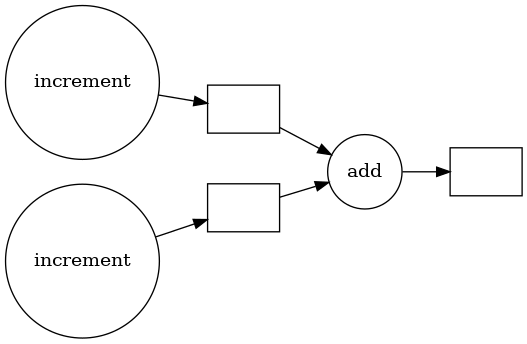

In [6]:
z.visualize(rankdir="LR")

As we can see from the computation graph, the two invokations of the *increment* function have been computed 
in parallel.

### Exercise 1: Parallelize a for loop

Let's try a parallelize a for loop.

The exercise consist in reading some numbers from a source by incrementing them and then by put them on a new source. At the end all the new numbers must to be sum.


In [7]:
def increment(x):
    sleep(1)
    return x + 1

data = [1, 2, 3, 4, 5, 6, 7, 8]


Let's see the source of non-parallelize code:

In [8]:
import time
start = time.time()
# Sequential code

results = []
for x in data:
    y = increment(x)
    results.append(y)
    
result = sum(results)
end = time.time()
print("After computing : {}".format(result))
print("Computation took {}s".format(round(end-start), 2))

After computing : 44
Computation took 8s


Here there is the partial code of the parallelized code, fill the blank spaces by yourself.


In [9]:
import time
start = time.time()

results = []

for x in data:
    y =   delayed(increment)(x)
    results.append(y)
    
total =  delayed(sum)(results) 
result = total.compute()
end = time.time()
print("After computing : {}".format(result))
print("Computation took {}s".format(round(end-start), 2))

After computing : 44
Computation took 2s


### Exercise2 : Parallelizing a for-loop code with control flow


This exercise is quite similar to the first one.

The exercise consist in reading some numbers from a source by checking if the current number is even or odd throught the usage of ```is_even``` function . If the number is even it must be doubled by using function ```double```, otherwise it must be increment by using function ```increment```. Once the number has been processed in the right way it must be put on a new source. At the end all the new numbers must to be sum.


In [10]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

def increment(x):
    sleep(1)
    return x + 1

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Let's see the source of non-parallelize code:

In [11]:
import time
start = time.time()

# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = increment(x)
    results.append(y)
    
result = sum(results)
end = time.time()
print("After computing :", result)
print("Computation took {}s".format(round(end-start), 2))

After computing : 90
Computation took 10s


try to parallelize:

In [12]:
import time
start = time.time()
results = []
for x in data:
    if is_even(x):  # even
        y =  delayed(double)(x)
    else:          # odd
        y = delayed(increment)(x)
    results.append(y)
    
total = delayed(sum)(results)
result = total.compute()
end = time.time()
print("After computing :", result)
print("Computation took {}s".format(round(end-start), 2))

After computing : 90
Computation took 3s


### Exercise 3: Sum reduction on a tree

This exercise is an example of a non-trivial algorithm, consider the classic tree reduction. 
Here there is a schema on wath you have to do:

```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

Here there is a "simple" algorithm with nested for loop and a bit of normal Python logic.

In [13]:
import time

start = time.time()
L = [1, 3, 4, 5, 6, 7, 8, 10]


while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L 
    
print(L[0])
end = time.time()
print("Computation took {}s".format(round(end-start), 2))

44
Computation took 7s


Try to parallelize the algorithm:

In [15]:
import time

start = time.time()

L = [1, 3, 4, 5, 6, 7, 8, 10]
result = None
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = delayed(add)(L[i], L[i+1])
        new_L.append(lazy)
    L = new_L 

print(L[0].compute()) 
end = time.time()
print("Computation took {}s".format(round(end-start), 2))

44
Computation took 3s


Modify the previous code in oder to visualize the computation graph

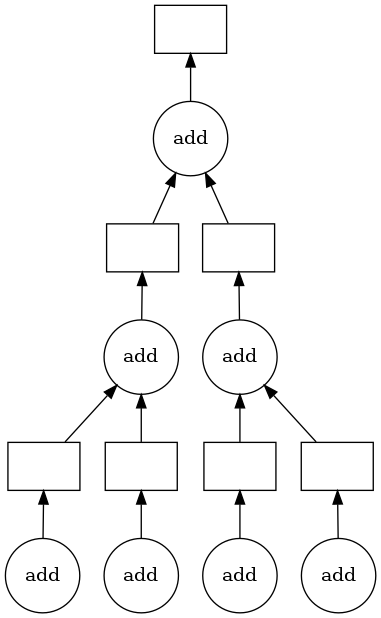

In [16]:
import time

start = time.time()

L = [1, 3, 4, 5, 6, 7, 8, 10]
result = None
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = delayed(add)(L[i], L[i + 1])
        new_L.append(lazy)
    L = new_L 
display(L[0].visualize())

### Exercise 4: Monte Carlo Integration... What is happening??

In [17]:
import numpy as np

def f(x):
    return (np.sin(1/(x*(2-x))))**2


Let's see the normal code

In [21]:
import time

start = time.time()

# Monte Carlo integration
N=20000
count=[]
def get_value():
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): 
        return 1
    else:
        return 0
        
for i in range(N):
    count.append(get_value())
    
I=2*sum(count)/N
print(I)
end = time.time()
print("Computation took {}s".format(round(end-start), 2))


1.4476
Computation took 0s


In [25]:
import time

start = time.time()

# Monte Carlo integration
N=20000
count=[]
def get_value():
    x=2*np.random.random()
    y=np.random.random()
    return y<f(x)

for i in range(N):
    h = delayed(get_value)()
    count.append(h)
    ## put your code here

real_count = delayed(sum)(count)##put your code here
I=2*real_count.compute()/N
print(I)
end = time.time()
print("Computation took {}s".format(round(end-start), 2))


1.4439
Computation took 9s


Try to visualize the graph

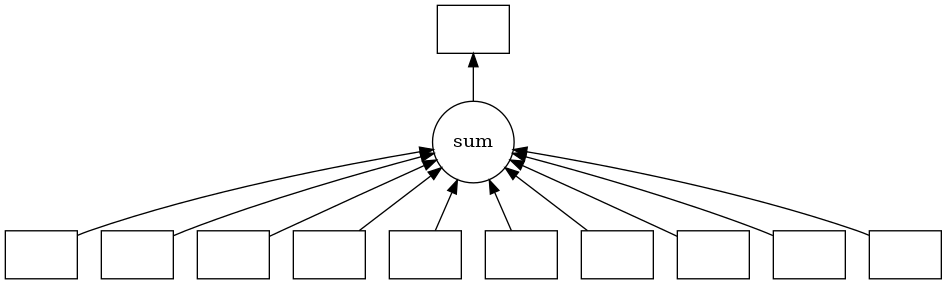

In [24]:
import time

start = time.time()

# Monte Carlo integration
N=10
count=[]
def get_value():
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): 
        return 1
    else:
        return 0
        
for i in range(N):
    count.append(delayed(get_value())) 

real_count = delayed(sum)(count)  
display(real_count.visualize()) 
